## Setup

In [1]:
source("2022_PSVD_metabolomics/2022_PSVD_metabolomics/R/00_setup.R")

In [2]:
p_load("dplyr", "ggplot2", "mice", "janitor", "POMA", "SummarizedExperiment", "DESeq2", install = FALSE)

Warning message in p_load("dplyr", "ggplot2", "mice", "janitor", "POMA", "SummarizedExperiment", :
“Failed to install/load:
mice”


## BoxPlots

In [3]:
vienna <- read.csv("outputs/01_metabolomics_merged.csv")
barcelona <- read.csv("outputs/06_metabolites_normalized.csv")

In [4]:
vienna_meta <- read.csv("outputs/01_metadata.csv")
barcelona_meta <- read.csv("data/validation/metabolite_counts_gp.csv")

In [5]:
vienna_meta <- vienna_meta %>% select(sample_id, sample_description)
vienna <- vienna %>% select(sample_id, HMDB0000191, HMDB0000036) %>% left_join(., vienna_meta, by = "sample_id") %>% dplyr::rename(taurocholic_vie = "HMDB0000036", aspartic_vie = "HMDB0000191")

In [6]:
barcelona_meta <- barcelona_meta %>% select(c(OWL.code, GRUPO))
barcelona_meta <- barcelona_meta %>% dplyr::rename(owl_code = "OWL.code", sample_description = GRUPO) 

In [7]:
barcelona <- barcelona %>% dplyr::rename(owl_code = X)

In [8]:
barcelona <- left_join(barcelona, barcelona_meta, by = "owl_code")

In [9]:
barcelona <- barcelona %>% mutate(sample_description = case_when(
    sample_description == "CIRROSIS" ~ "Cirrhosis",
    sample_description == "sano" ~ "Control",
    sample_description == "IPH" ~ "PSVD",
     .default = as.character(sample_description)
))

In [10]:
barcelona <- barcelona %>% select(owl_code, sample_description, taurocholic_acid, aspartic_acid) %>% filter(!owl_code %in% c("Owl-IPH-001",
                                            "Owl-IPH-005",
                                            "Owl-IPH-006",
                                            "Owl-IPH-009",
                                            "Owl-IPH-014",
                                            "Owl-IPH-015",
                                            "Owl-IPH-022",
                                            "Owl-IPH-023",
                                            "Owl-IPH-024",
                                            "Owl-IPH-026",
                                            "Owl-IPH-028",
                                            "Owl-IPH-030",
                                            "Owl-IPH-031",
                                            "Owl-IPH-033",
                                            "Owl-IPH-035",
                                            "Owl-IPH-040",
                                            "Owl-IPH-073",
                                            "Owl-IPH-071",
                                            "Owl-IPH-104"))

In [11]:
barcelona <- barcelona %>% dplyr::rename(sample_id = "owl_code")

In [12]:
vienna <- vienna %>% dplyr::rename(taurocholic_acid = taurocholic_vie, aspartic_acid = aspartic_vie)

In [13]:
barcelona$source = "barcelona"
vienna$source = "vienna"

In [14]:
merged <- rbind(vienna, barcelona)

In [15]:
long_df <- reshape2::melt(merged, id.vars = c("sample_id", "sample_description", "source"),
                measure.vars = c("aspartic_acid", "taurocholic_acid"),
                variable.name = "Compound", value.name = "Concentration")

In [16]:
long_df$sample_description <- factor(long_df$sample_description, levels = c("PSVD", "Cirrhosis", "Control"))

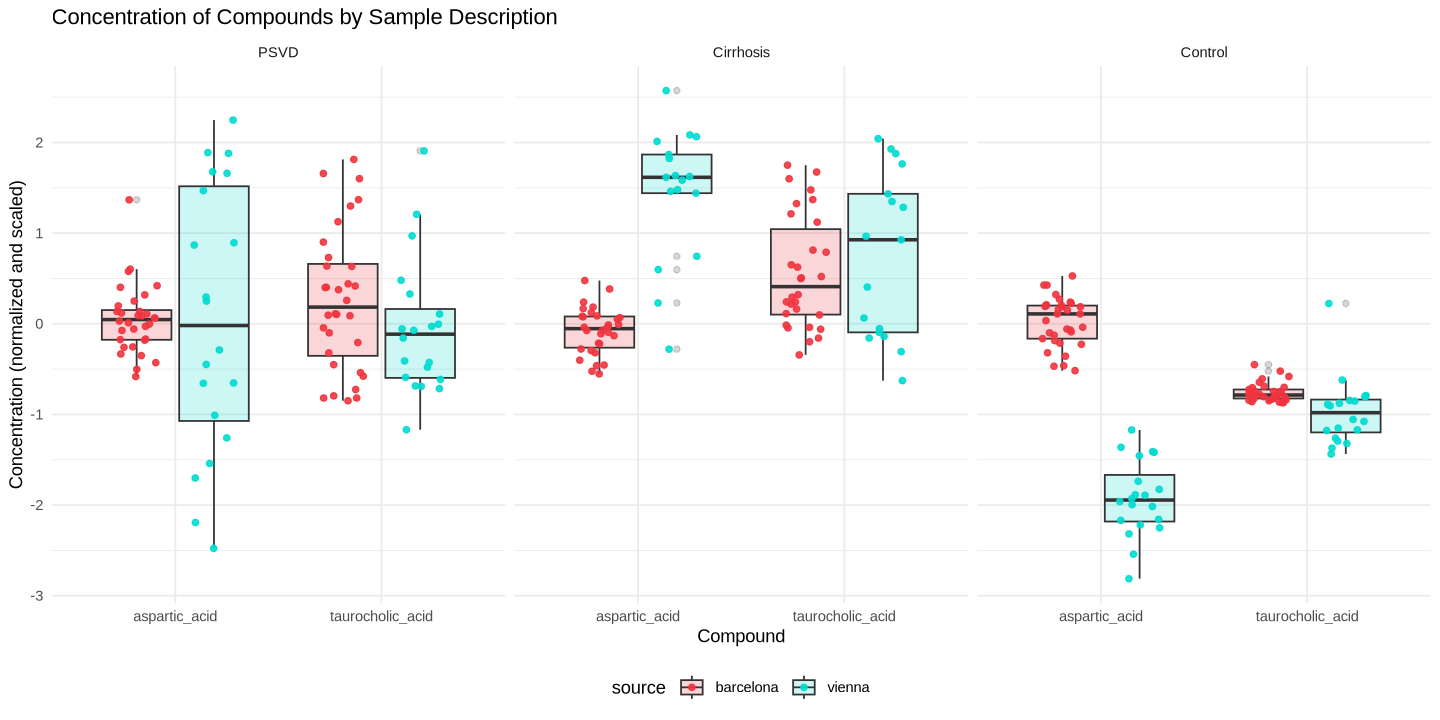

In [17]:
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(long_df, aes(x = Compound, y = Concentration, fill = source)) +
  geom_boxplot(alpha = 0.20) +  # Set alpha for boxplot to make jitter dots more visible
  geom_jitter(aes(color = source), position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.75), alpha = 0.9, size = 1.5) +
  facet_wrap(~sample_description) +
  theme_minimal() +
  labs(title = "Concentration of Compounds by Sample Description",
       x = "Compound",
       y = "Concentration (normalized and scaled)") +
  scale_fill_manual(values = c("vienna" = "#01dbd0", "barcelona" = "#ef353f")) +  # Set custom fill colors
  scale_color_manual(values = c("vienna" = "#01dbd0", "barcelona" = "#ef353f")) +
  theme(legend.position = "bottom")

In [18]:
long_df_psvd <- long_df %>% filter(sample_description %in% "PSVD")
long_df_ctrl <- long_df %>% filter(sample_description %in% "Control")

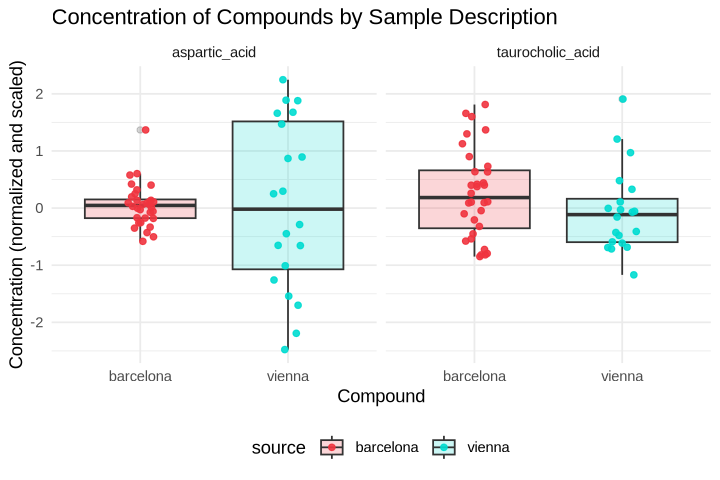

In [19]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(long_df_psvd, aes(x = source, y = Concentration, fill = source)) +
  geom_boxplot(alpha = 0.20) +  # Set alpha for boxplot to make jitter dots more visible
  geom_jitter(aes(color = source), position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.75), alpha = 0.9, size = 1.5) +
  facet_wrap(~Compound) +
  theme_minimal() +
  labs(title = "Concentration of Compounds by Sample Description",
       x = "Compound",
       y = "Concentration (normalized and scaled)") +
  scale_fill_manual(values = c("vienna" = "#01dbd0", "barcelona" = "#ef353f")) +  # Set custom fill colors
  scale_color_manual(values = c("vienna" = "#01dbd0", "barcelona" = "#ef353f")) +
  theme(legend.position = "bottom")

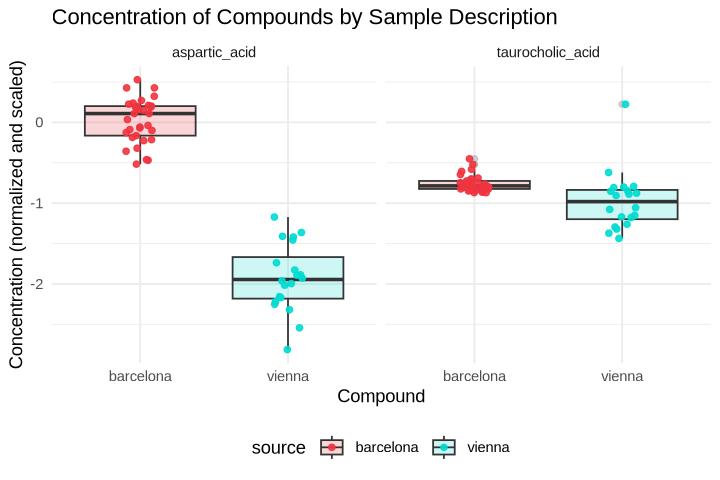

In [20]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(long_df_ctrl, aes(x = source, y = Concentration, fill = source)) +
  geom_boxplot(alpha = 0.20) +  # Set alpha for boxplot to make jitter dots more visible
  geom_jitter(aes(color = source), position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.75), alpha = 0.9, size = 1.5) +
  facet_wrap(~Compound) +
  theme_minimal() +
  labs(title = "Concentration of Compounds by Sample Description",
       x = "Compound",
       y = "Concentration (normalized and scaled)") +
  scale_fill_manual(values = c("vienna" = "#01dbd0", "barcelona" = "#ef353f")) +  # Set custom fill colors
  scale_color_manual(values = c("vienna" = "#01dbd0", "barcelona" = "#ef353f")) +
  theme(legend.position = "bottom")

In [21]:
long_df_vienna <- long_df %>% filter(source == "vienna", sample_description %in% c("PSVD", "Cirrhosis"))
long_df_barcelona <- long_df  %>% filter(source == "barcelona", sample_description %in% c("PSVD", "Cirrhosis"))

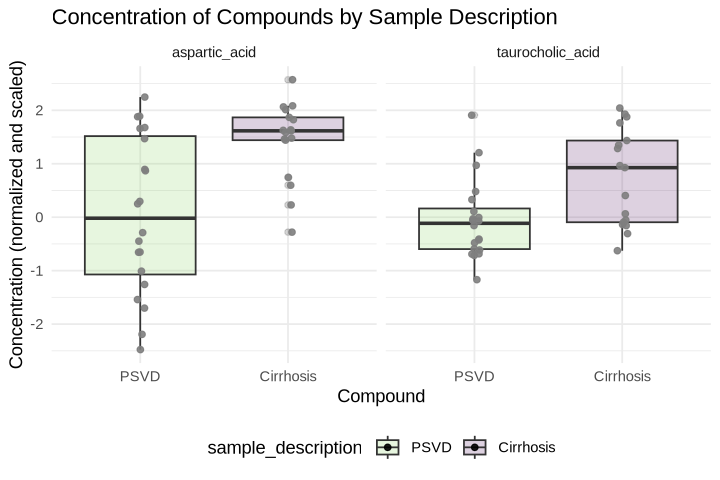

In [22]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(long_df_vienna, aes(x = sample_description, y = Concentration, fill = sample_description)) +
  geom_boxplot(alpha = 0.20) +  # Set alpha for boxplot to make jitter dots more visible
  geom_jitter(aes(color = source), position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.75), alpha = 0.9, size = 1.5) +
  facet_wrap(~Compound) +
  theme_minimal() +
  labs(title = "Concentration of Compounds by Sample Description",
       x = "Compound",
       y = "Concentration (normalized and scaled)") +
  scale_fill_manual(values = c("PSVD" = "#87D662", "Cirrhosis" = "#561965")) +  # Set custom fill colors
  scale_color_manual(values = c("PSVD" = "#87D662", "Cirrhosis" = "#561965")) +
  theme(legend.position = "bottom")

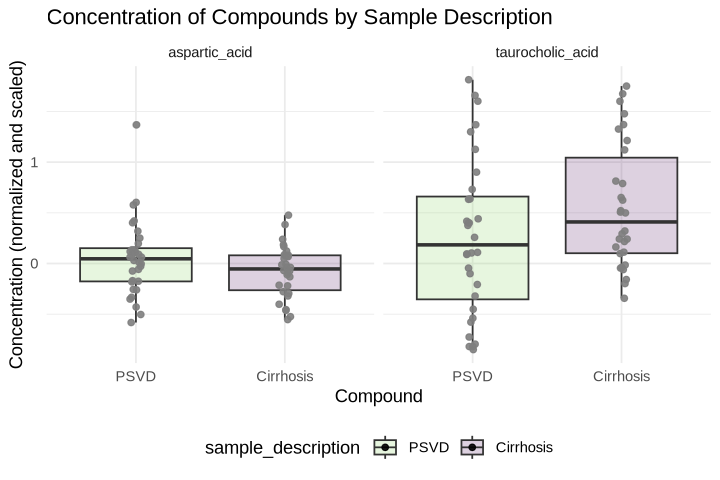

In [23]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(long_df_barcelona, aes(x = sample_description, y = Concentration, fill = sample_description)) +
  geom_boxplot(alpha = 0.20) +  # Set alpha for boxplot to make jitter dots more visible
  geom_jitter(aes(color = source), position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.75), alpha = 0.9, size = 1.5) +
  facet_wrap(~Compound) +
  theme_minimal() +
  labs(title = "Concentration of Compounds by Sample Description",
       x = "Compound",
       y = "Concentration (normalized and scaled)") +
  scale_fill_manual(values = c("PSVD" = "#87D662", "Cirrhosis" = "#561965")) +  # Set custom fill colors
  scale_color_manual(values = c("PSVD" = "#87D662", "Cirrhosis" = "#561965")) +
   theme(legend.position = "bottom")

In [32]:
long_df_vienna_hc <- long_df %>% filter(source == "vienna", sample_description %in% c("PSVD", "Control"))
long_df_barcelona_hc <- long_df  %>% filter(source == "barcelona", sample_description %in% c("PSVD", "Control"))

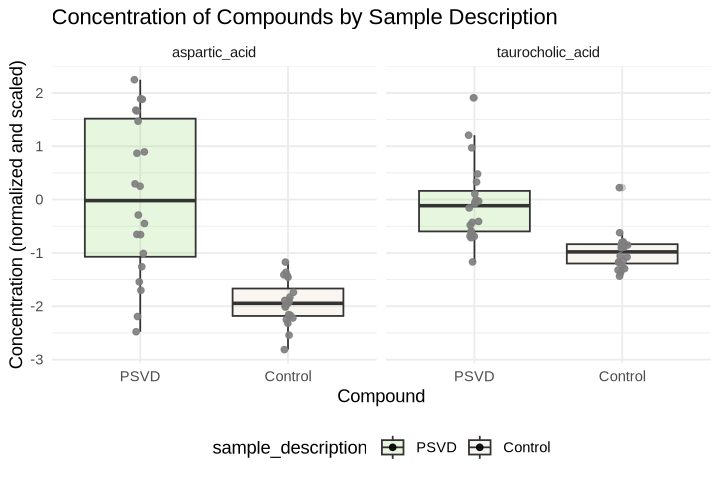

In [35]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(long_df_vienna_hc, aes(x = sample_description, y = Concentration, fill = sample_description)) +
  geom_boxplot(alpha = 0.20) +  # Set alpha for boxplot to make jitter dots more visible
  geom_jitter(aes(color = source), position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.75), alpha = 0.9, size = 1.5) +
  facet_wrap(~Compound) +
  theme_minimal() +
  labs(title = "Concentration of Compounds by Sample Description",
       x = "Compound",
       y = "Concentration (normalized and scaled)") +
  scale_fill_manual(values = c("PSVD" = "#87D662", "Control" = "#e2d2bb")) +  # Set custom fill colors
  scale_color_manual(values = c("PSVD" = "#87D662", "Control" = "#e2d2bb")) +
  theme(legend.position = "bottom")

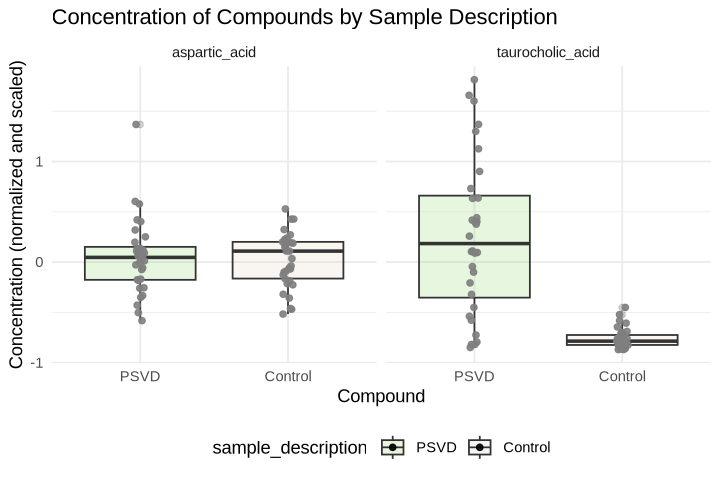

In [36]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(long_df_barcelona_hc, aes(x = sample_description, y = Concentration, fill = sample_description)) +
  geom_boxplot(alpha = 0.20) +  # Set alpha for boxplot to make jitter dots more visible
  geom_jitter(aes(color = source), position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.75), alpha = 0.9, size = 1.5) +
  facet_wrap(~Compound) +
  theme_minimal() +
  labs(title = "Concentration of Compounds by Sample Description",
       x = "Compound",
       y = "Concentration (normalized and scaled)") +
  scale_fill_manual(values = c("PSVD" = "#87D662", "Control" = "#e2d2bb")) +  # Set custom fill colors
  scale_color_manual(values = c("PSVD" = "#87D662", "Control" = "#e2d2bb")) +
  theme(legend.position = "bottom")

## Tests

In [24]:
tests_fun <- function(input_df) {
  normality_tests <- input_df %>%
    group_by(sample_description, Compound, source) %>%
    summarise(shapiro_test = shapiro.test(Concentration)$p.value, .groups = 'drop') %>%
    mutate(normal = shapiro_test > 0.05)  # Assuming alpha = 0.05

  print(normality_tests)
}


In [25]:
long_df_psvd %>% filter(Compound == "aspartic_acid")

sample_id,sample_description,source,Compound,Concentration
<chr>,<fct>,<chr>,<fct>,<dbl>
2358,PSVD,vienna,aspartic_acid,1.6773261
2390,PSVD,vienna,aspartic_acid,1.4695695
2427,PSVD,vienna,aspartic_acid,1.6600934
2432,PSVD,vienna,aspartic_acid,0.2502914
2588,PSVD,vienna,aspartic_acid,0.2952406
2621,PSVD,vienna,aspartic_acid,2.2472515
2658,PSVD,vienna,aspartic_acid,1.8886140
2675,PSVD,vienna,aspartic_acid,0.8683313
2805,PSVD,vienna,aspartic_acid,0.8941888


In [26]:
tests_fun(long_df_psvd)
tests_fun(long_df_ctrl)

# A tibble: 4 × 5
  sample_description Compound         source    shapiro_test normal
  <fct>              <fct>            <chr>            <dbl> <lgl> 
1 PSVD               aspartic_acid    barcelona       0.0151 FALSE 
2 PSVD               aspartic_acid    vienna          0.302  TRUE  
3 PSVD               taurocholic_acid barcelona       0.165  TRUE  
4 PSVD               taurocholic_acid vienna          0.0593 TRUE  
# A tibble: 4 × 5
  sample_description Compound         source    shapiro_test normal
  <fct>              <fct>            <chr>            <dbl> <lgl> 
1 Control            aspartic_acid    barcelona     0.335    TRUE  
2 Control            aspartic_acid    vienna        0.802    TRUE  
3 Control            taurocholic_acid barcelona     0.000937 FALSE 
4 Control            taurocholic_acid vienna        0.00315  FALSE 


In [27]:
wilcox.test(Concentration ~ source, data = long_df_psvd %>% filter(Compound == "aspartic_acid"))
t.test(Concentration ~ source, data = long_df_psvd %>% filter(Compound == "taurocholic_acid"))

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Concentration by source
W = 328, p-value = 0.8878
alternative hypothesis: true location shift is not equal to 0



	Welch Two Sample t-test

data:  Concentration by source
t = 1.4461, df = 41.777, p-value = 0.1556
alternative hypothesis: true difference in means between group barcelona and group vienna is not equal to 0
95 percent confidence interval:
 -0.1232394  0.7461211
sample estimates:
mean in group barcelona    mean in group vienna 
             0.25662500             -0.05481588 


In [28]:
wilcox.test(Concentration ~ source, data = long_df_ctrl %>% filter(Compound == "aspartic_acid"))
wilcox.test(Concentration ~ source, data = long_df_ctrl %>% filter(Compound == "taurocholic_acid"))

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Concentration by source
W = 660, p-value = 1.48e-09
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Concentration by source
W = 551, p-value = 5.189e-05
alternative hypothesis: true location shift is not equal to 0


In [29]:
tests_fun(long_df_vienna)
tests_fun(long_df_barcelona)

# A tibble: 4 × 5
  sample_description Compound         source shapiro_test normal
  <fct>              <fct>            <chr>         <dbl> <lgl> 
1 PSVD               aspartic_acid    vienna       0.302  TRUE  
2 PSVD               taurocholic_acid vienna       0.0593 TRUE  
3 Cirrhosis          aspartic_acid    vienna       0.0721 TRUE  
4 Cirrhosis          taurocholic_acid vienna       0.0888 TRUE  
# A tibble: 4 × 5
  sample_description Compound         source    shapiro_test normal
  <fct>              <fct>            <chr>            <dbl> <lgl> 
1 PSVD               aspartic_acid    barcelona       0.0151 FALSE 
2 PSVD               taurocholic_acid barcelona       0.165  TRUE  
3 Cirrhosis          aspartic_acid    barcelona       0.792  TRUE  
4 Cirrhosis          taurocholic_acid barcelona       0.0321 FALSE 


In [30]:
t.test(Concentration ~ sample_description, data = long_df_vienna %>% filter(Compound == "aspartic_acid"))
wilcox.test(Concentration ~ sample_description, data = long_df_vienna %>% filter(Compound == "taurocholic_acid"))


	Welch Two Sample t-test

data:  Concentration by sample_description
t = -3.7346, df = 28.632, p-value = 0.0008304
alternative hypothesis: true difference in means between group PSVD and group Cirrhosis is not equal to 0
95 percent confidence interval:
 -2.1662326 -0.6325961
sample estimates:
     mean in group PSVD mean in group Cirrhosis 
             0.04517287              1.44458722 



	Wilcoxon rank sum exact test

data:  Concentration by sample_description
W = 87, p-value = 0.01069
alternative hypothesis: true location shift is not equal to 0


In [31]:
wilcox.test(Concentration ~ sample_description, data = long_df_barcelona %>% filter(Compound == "aspartic_acid"))
wilcox.test(Concentration ~ sample_description, data = long_df_barcelona %>% filter(Compound == "taurocholic_acid"))

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Concentration by sample_description
W = 581, p-value = 0.1569
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Concentration by sample_description
W = 365.5, p-value = 0.1083
alternative hypothesis: true location shift is not equal to 0


In [37]:
tests_fun(long_df_vienna_hc)
tests_fun(long_df_barcelona_hc)

# A tibble: 4 × 5
  sample_description Compound         source shapiro_test normal
  <fct>              <fct>            <chr>         <dbl> <lgl> 
1 PSVD               aspartic_acid    vienna      0.302   TRUE  
2 PSVD               taurocholic_acid vienna      0.0593  TRUE  
3 Control            aspartic_acid    vienna      0.802   TRUE  
4 Control            taurocholic_acid vienna      0.00315 FALSE 
# A tibble: 4 × 5
  sample_description Compound         source    shapiro_test normal
  <fct>              <fct>            <chr>            <dbl> <lgl> 
1 PSVD               aspartic_acid    barcelona     0.0151   FALSE 
2 PSVD               taurocholic_acid barcelona     0.165    TRUE  
3 Control            aspartic_acid    barcelona     0.335    TRUE  
4 Control            taurocholic_acid barcelona     0.000937 FALSE 


In [39]:
t.test(Concentration ~ sample_description, data = long_df_vienna_hc %>% filter(Compound == "aspartic_acid"))
wilcox.test(Concentration ~ sample_description, data = long_df_vienna_hc %>% filter(Compound == "taurocholic_acid"))


	Welch Two Sample t-test

data:  Concentration by sample_description
t = 5.7413, df = 22.017, p-value = 8.916e-06
alternative hypothesis: true difference in means between group PSVD and group Control is not equal to 0
95 percent confidence interval:
 1.259502 2.683879
sample estimates:
   mean in group PSVD mean in group Control 
           0.04517287           -1.92651774 



	Wilcoxon rank sum exact test

data:  Concentration by sample_description
W = 370, p-value = 4.071e-07
alternative hypothesis: true location shift is not equal to 0


In [38]:
wilcox.test(Concentration ~ sample_description, data = long_df_barcelona_hc %>% filter(Compound == "aspartic_acid"))
wilcox.test(Concentration ~ sample_description, data = long_df_barcelona_hc %>% filter(Compound == "taurocholic_acid"))

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Concentration by sample_description
W = 506, p-value = 0.7778
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  Concentration by sample_description
W = 949, p-value = 3.417e-08
alternative hypothesis: true location shift is not equal to 0
